In [2]:
from google.colab import drive
drive.mount('/content/drive/')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%%capture
!pip install syft

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt

from torch import optim
import torchvision.transforms.functional as TF
from torchvision import transforms

from torch.utils.data import random_split
from torch.utils.data import DataLoader


In [0]:
path_exp_1 = "/content/drive/My Drive//Raw_Data/experiment-i/"
positions = ["justAPlaceholder","supine", "right", "left", "right", "right", "left", "left", "supine", "supine", "supine", "supine", "supine", "right", "left", "supine", "supine", "supine"]

subjects_dict = {}


Normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
  ])

for _, dirs, _ in os.walk(path_exp_1):
  for directory in dirs:
    # each directory is a subject
    subject = directory
    data = None
    labels = None
    
    for _, _, files in os.walk(os.path.join(path_exp_1, directory)):
      for file in files:
        file_path = os.path.join(path_exp_1, directory, file)
        with open(file_path, 'r') as f:
          # Start from second recording, as the first two are corrupted
          for line in f.read().splitlines()[2:]:
            def token_position(x):
              return {
                'supine': 0,
                'left': 1,
                'right': 2,
                'left_fetus': 1,
                'right_fetus': 2
              }[x]
            
            
            raw_data = np.fromstring(line, dtype=float, sep='\t')
            file_data = np.round(raw_data*255/1000).astype(np.uint8) # Change the range from [0-1000] to [0-255]. This allows us to use tranforms later.
            file_data = Normalize(file_data.reshape(64,32))
            file_data = file_data.view(1, 64, 32)
            file_label = token_position(positions[int(file[:-4])]) # Turn the file index into position list, and turn position list into reduced indices.
            file_label = np.array([file_label])
            
            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)

            if labels is None:
              labels = file_label
            else:
              labels = np.concatenate((labels, file_label), axis=0)
              
    subjects_dict[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

In [0]:
path_exp_2 = "/content/drive/My Drive/Raw_Data/experiment-ii/"

positions = {
    "B":"supine",
    "1":"supine",
    "C":"right",
    "D":"left",
    "E1":"right",
    "E2":"right",
    "E3":"left",
    "E4":"left",
    "E5":"right",
    "E6":"left",
    "F":"supine",
    "G1":"supine",
    "G2":"right",
    "G3":"left"
}

def token_position(x):
  return {
    'supine': 0,
    'left': 1,
    'right': 2
  }[x]

subjects_dict_air = {}
subjects_dict_spo = {}

def resize_and_rotate(image):
  To_PIL_and_Resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 32))
  ])
  rotated = TF.rotate(To_PIL_and_Resize(image), angle=180)
  return transforms.ToTensor()(rotated)


# each directory is a subject
for _, subject_dirs, _ in os.walk(path_exp_2):
  for subject in subject_dirs:
    data = None
    labels = None
    
    # each directory is a matresss
    for _, mat_dirs, _ in os.walk(os.path.join(path_exp_2, subject)):
      for mat in mat_dirs:
        for _, _, files in os.walk(os.path.join(path_exp_2, subject, mat)):

          for file in files:

            file_path = os.path.join(path_exp_2, subject, mat, file)
            raw_data = np.loadtxt(file_path)
            file_data = np.round(raw_data*255/500).astype(np.uint8) # Change the range from [0-500] to [0-255]. This allows us to use tranforms later. 
            file_data = resize_and_rotate(file_data)
            file_data = file_data.view(1, 64, 32)
            
            if file[-6] == "E" or file[-6] == "G":
              file_label = positions[file[-6:-4]]
            else:
              file_label = positions[file[-6]]
            
            file_label = token_position(file_label)
            file_label = np.array([file_label])           

            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)

            if labels is None:
              labels = file_label
            else:
              labels = np.concatenate((labels, file_label), axis=0)
        
        if mat == "Air_Mat":                        
          subjects_dict_air[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
        else:
          subjects_dict_spo[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
        
        data = None
        labels = None

In [0]:
datasets = {
    "Base":subjects_dict,
    "Spo":subjects_dict_spo,
    "Air":subjects_dict_air
}

from torch.utils.data import Dataset

class Mat_Dataset(Dataset):
  def __init__(self, mats, Subject_IDs):
    
    self.samples = []
    self.labels = []
    
    for mat in mats:
      data = datasets[mat]
      self.samples.append(np.vstack([data.get(key)[0] for key in Subject_IDs]))
      self.labels.append(np.hstack([data.get(key)[1] for key in Subject_IDs]))
      
    self.samples = np.vstack(self.samples)
    self.labels = np.hstack(self.labels)
    
  def __len__(self):
    return self.samples.shape[0]
      
  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

PyTorch gives you the freedom to pretty much do anything with the Dataset class so long as you override two of the subclass functions:

+ the __len__ function which returns the size of the dataset, and
+ the __getitem__ function which returns a sample from the dataset given an index.

In [0]:


data_exp_1 = Mat_Dataset(["Base"], [key for key in subjects_dict.keys()])

trainset_exp_1, valset_exp_1 = random_split(data_exp_1, [round(len(data_exp_1)*0.70), len(data_exp_1) - round(len(data_exp_1)*0.70)])

trainloader = DataLoader(trainset_exp_1, batch_size=64, shuffle=True)
testloader = DataLoader(valset_exp_1, batch_size=64, shuffle=False)

In [9]:
import torch
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Input channels = 1, output channels = 6
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(18 * 16 * 8, 392)
        self.h2 = nn.Linear(392, 98)
        
        # Output layer, 3 neurons - one for each position
        self.output = nn.Linear(98, 3)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.float()
        # Add a "channel dimension"
        x = x.unsqueeze(1)
        
        #Computes the activation of the first convolution
        #Size changes from (1, 64, 32) to (6, 64, 32)
        
        x = F.relu(self.conv1(x))

        # LOOK HERE
        #Size changes from (6, 32, 16) to (6, 32, 16)
        x = self.pool(x)

        
        #Size changes from (6, 32, 16) to (18, 32, 16)
        x = F.relu(self.conv2(x))

        
        #Size changes from (18, 32, 16) to (18, 16, 8)
        x = self.pool(x)
        
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        x = self.h1(x)

        x = self.relu(x)
        x = self.h2(x)

        x = self.relu(x)
        x = self.output(x)

        x = self.logsoftmax(x)
        
        return x

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=3, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

In [0]:
def train_model(device, trainloader, testloader=None):
  model = Network()

  criterion = nn.NLLLoss()

  optimizer = optim.Adam(model.parameters(), lr = 0.01)

  model.to(device)

  epochs = 15
  running_loss = 0

  torch.manual_seed(123)

  train_losses, test_losses = [], []

  for epoch in range(epochs):
    for inputs, labels in trainloader:

      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    else:

      if testloader != None:
        
        test_loss = 0
        accuracy = 0
        model.eval()

        with torch.no_grad():
          for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            test_loss += criterion(logps, labels)

            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {accuracy/len(testloader):.3f}")
        running_loss = 0
        model.train()


  plt.plot(train_losses, label='Training loss')
  #plt.plot(test_losses, label='Validation loss')
  plt.legend(frameon=False)
  return model

Working on: cuda
Accuracy 0.828
Accuracy 0.875
Accuracy 0.917
Accuracy 0.738
Accuracy 0.837
Accuracy 0.869
Accuracy 0.816
Accuracy 0.857
Accuracy 0.827
Accuracy 0.882


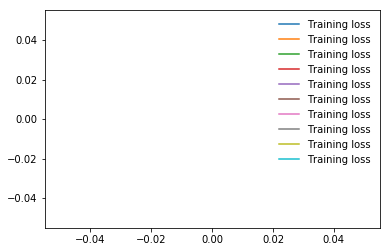

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on: {device.type}")

hospitals = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

hospitals_preds = {}

my_hospital = ["S11", "S12", "S13"]

my_data = Mat_Dataset(["Base"], my_hospital)
my_data_loader = DataLoader(my_data, batch_size=len(my_data), shuffle=False)

for hospital in hospitals:
  private_data = Mat_Dataset(["Base"], [hospital])
  private_data_loader = DataLoader(private_data, batch_size=64, shuffle=True)
  private_model = train_model(device, private_data_loader)
  
  accuracy = 0
  private_model.to(device)
  private_model.eval()
  with torch.no_grad():
      
    for inputs, labels in my_data_loader:

      inputs, labels = inputs.to(device), labels.to(device)
      logps = private_model.forward(inputs)
      ps = torch.exp(logps)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))
      print(f"Accuracy {accuracy/len(my_data_loader):.3f}")
      hospitals_preds[hospital] = top_class
    
  

In [0]:
#Images x Hospitals

#hospital_p.shape

hospital_p = np.hstack([hospitals_preds.get(key).cpu() for key in hospitals_preds.keys()])
num_positions = 3

def hospitals_vote(hospital_p, epsilon=0.1):
  new_labels = list()

  for a_measurement in hospital_p:

    label_counts = np.bincount(a_measurement, minlength=num_positions)

    beta = 1 / epsilon

    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    new_label = np.argmax(label_counts)

    new_labels.append(new_label)
  
  return np.array(new_labels)

(4324, 10)

In [130]:
from syft.frameworks.torch.differential_privacy import pate

indices = hospitals_vote(hospital_p, epsilon=0.01)
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=hospital_p.transpose(), indices=indices, noise_eps=0.01, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

sum(np.array(indices) == tr_d)/np.shape(np.array(indices) == tr_d)[0]

Data Independent Epsilon: 7.202231366242557
Data Dependent Epsilon: 7.202231366242335


0.3503700277520814

In [0]:
# True
tr_d = my_data[:][1]

In [134]:
indices = hospitals_vote(hospital_p, epsilon=0.5)
sum(np.array(indices) == tr_d)/np.shape(np.array(indices) == tr_d)[0]

0.8896854764107308

In [136]:
np.random.laplace(0, 1/0.1, 1)

array([-13.52000765])